In [1]:
#library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as K
import time
import os
import matplotlib.image as img
from PIL import Image

from keras.layers import BatchNormalization,Dense,Dropout,Flatten,Reshape, Concatenate, concatenate,Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.losses import BinaryCrossentropy


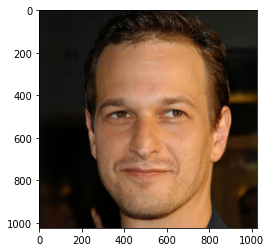

(1024, 1024, 3)


In [2]:
allImgPath = []
fullImgPath = "C:/Users/Belg/Downloads/archive(1)/celeba_hq/train/male"

for path in os.listdir(fullImgPath):
    if ".jpg" in path:
        allImgPath.append(os.path.join(fullImgPath,path))

image = img.imread(allImgPath[0])
plt.imshow(image)
plt.show()
print(image.shape)

In [3]:
partImgPath = allImgPath[0:8000]
#cropping = (30,55,160,190)
xTrain = [np.array((Image.open(path).convert('L')).resize((512,512))) for path in partImgPath]

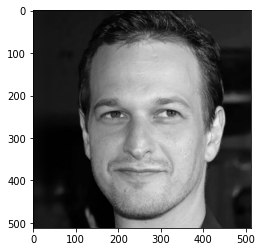

(512, 512)


In [4]:
plt.imshow(xTrain[0],cmap="gray")
plt.show()
print(xTrain[0].shape)

In [5]:
for i in range(len(xTrain)):
    xTrain[i] = xTrain[i]/127.5-1 #tanh -->[-1,1]

xTrain = np.array(xTrain)

In [6]:
#xTrain=xTrain[0:50000]
xTrain.shape

(8000, 512, 512)

<Figure size 720x720 with 0 Axes>

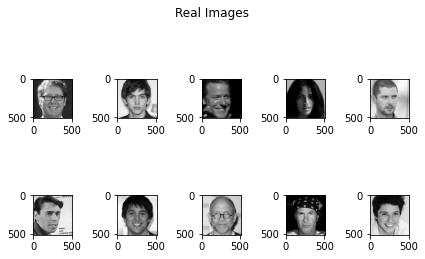

In [7]:
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("Real Images")
idx=8

for i in range(2):
    for j in range(5):
            ax[i,j].imshow(((xTrain[idx])* 0.5 + 0.5).reshape(512,512,1),cmap="gray")            
            idx+=6
            
plt.tight_layout()
plt.show()

In [2]:
batchSize = 32
nepochs = 100
zDim = 100
imgShape = (512,512,1)
sampleInterval = 1

In [9]:
with tf.device('/CPU:0'):
    trainDataset = tf.data.Dataset.from_tensor_slices(xTrain).shuffle(len(xTrain)).batch(batchSize)

In [3]:
oldgenerator = K.models.load_model("Celeb_a_CNNgenerator")
oldgenerator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1654784   
                                                                 
 batch_normalization_4 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)     

In [44]:
def buildnewGenerator():

    model = Sequential()
    model.add(oldgenerator)

    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    """model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())"""

    model.add(BatchNormalization())
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation="tanh"))
    
    return model

In [45]:
buildnewGenerator().summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 1)       2108801   
                                                                 
 conv2d_transpose_83 (Conv2D  (None, 256, 256, 1)      10        
 Transpose)                                                      
                                                                 
 batch_normalization_83 (Bat  (None, 256, 256, 1)      4         
 chNormalization)                                                
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 256, 256, 1)       0         
                                                                 
 batch_normalization_84 (Bat  (None, 256, 256, 1)      4         
 chNormalization)                                                
                                                     

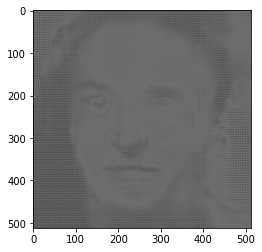

In [75]:
#generate noise image
newgenerator = buildnewGenerator()
noise = tf.random.normal([1, zDim])
generatedImage = newgenerator(noise, training=False)

plt.imshow((generatedImage[0])* 0.5 + 0.5,cmap="gray")
plt.show()


In [47]:
discriminator = K.models.load_model("Celeb_a_CNNdiscriminator")
discriminator.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 64, 64, 32)        0         
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)      

In [11]:
#classyfy with discriminator
decision = discriminator(generatedImage, training = False)
print (decision)

tf.Tensor([[3.9904624e-08]], shape=(1, 1), dtype=float32)


In [12]:
def buildGan(merged,discriminator):
    model = Sequential()
    model.add(merged)
    model.add(discriminator)
    return model


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 1)       2108801   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 404225    
                                                                 
Total params: 2,513,026
Trainable params: 2,075,585
Non-trainable params: 437,441
_________________________________________________________________


In [ ]:
buildGan(generator,discriminator).summary()

In [13]:
gan = buildGan(generator,discriminator)
decision = gan(noise,training = False)
print(decision)

tf.Tensor([[3.9904624e-08]], shape=(1, 1), dtype=float32)


In [14]:
discriminator.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

discriminator.trainable = False
gan.compile(loss="binary_crossentropy",optimizer="adam")

In [15]:
def train_step(images):
    noise = tf.random.normal([len(images),zDim])
    genImg = generator(noise)

    real = tf.ones([len(images),1])
    fake = tf.zeros([len(images),1])
    #for i in range(3):
    discriminator.trainable = True
    dreal = discriminator.train_on_batch(images,real)
    dfake = discriminator.train_on_batch(genImg, fake)
    disLoss, acc = 0.5*tf.add(dreal,dfake)
    
    discriminator.trainable = False
    genLoss = gan.train_on_batch(noise,real)

      
    return genLoss,disLoss,acc*100

In [21]:
def training():
    for epoch in range(nepochs):
      start = time.time()

      for batch in trainDataset:
        train_step(batch)
        genLoss,disLoss,acc = train_step(batch)
        
      if (epoch + 1) % sampleInterval ==0:
        print ('Time for epoch {} is {} sec'.format(epoch + 1, np.round(time.time()-start)))
        print("Epoch: ",epoch + 1,"| Discriminator Loss: ",np.round(tf.get_static_value(disLoss),2),"| Accuracy: ",np.round(tf.get_static_value(acc),2),"%","| Generator Loss: ",np.round(tf.get_static_value(genLoss),2))
        print("---------------------------------------------------------------------------------------------------------------------------------------------------------------")
        sampleImg(generator)

In [22]:
def sampleImg(generator,imgGridRow = 5, imgGridColumn = 5):
    noise = tf.random.normal([batchSize, zDim])
    genImg = generator.predict(noise)

    fig, axs = plt.subplots(imgGridRow,imgGridColumn,figsize=(5,5),sharey = True,sharex=True)
    cnt = 0
    for i in range(imgGridRow):
        for j in range(imgGridColumn):
            axs[i,j].imshow(genImg[cnt]* 0.5 + 0.5,cmap="gray")
            axs[i,j].axis("off")
            cnt+=1
    plt.show()

Time for epoch 1 is 402.0 sec
Epoch:  1 | Discriminator Loss:  0.0 | Accuracy:  100.0 % | Generator Loss:  0.0
---------------------------------------------------------------------------------------------------------------------------------------------------------------


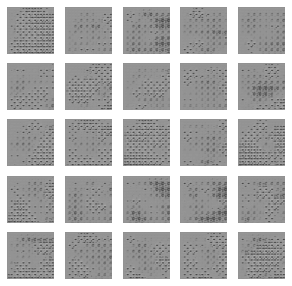

Time for epoch 2 is 395.0 sec
Epoch:  2 | Discriminator Loss:  0.0 | Accuracy:  100.0 % | Generator Loss:  0.0
---------------------------------------------------------------------------------------------------------------------------------------------------------------


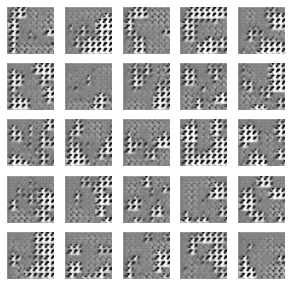

Time for epoch 3 is 396.0 sec
Epoch:  3 | Discriminator Loss:  1.89 | Accuracy:  98.44 % | Generator Loss:  47.98
---------------------------------------------------------------------------------------------------------------------------------------------------------------


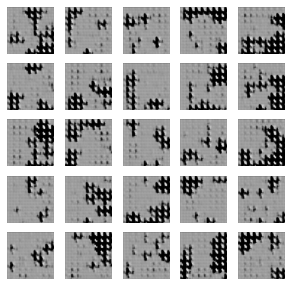

Time for epoch 4 is 397.0 sec
Epoch:  4 | Discriminator Loss:  0.0 | Accuracy:  100.0 % | Generator Loss:  0.0
---------------------------------------------------------------------------------------------------------------------------------------------------------------


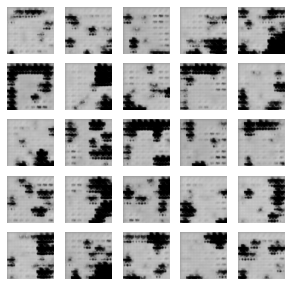

Time for epoch 5 is 398.0 sec
Epoch:  5 | Discriminator Loss:  1.45 | Accuracy:  93.75 % | Generator Loss:  21.51
---------------------------------------------------------------------------------------------------------------------------------------------------------------


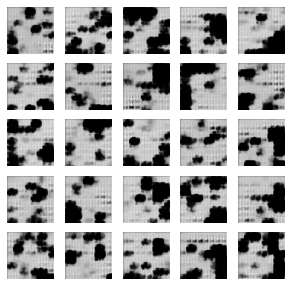

Time for epoch 6 is 399.0 sec
Epoch:  6 | Discriminator Loss:  0.0 | Accuracy:  100.0 % | Generator Loss:  0.0
---------------------------------------------------------------------------------------------------------------------------------------------------------------


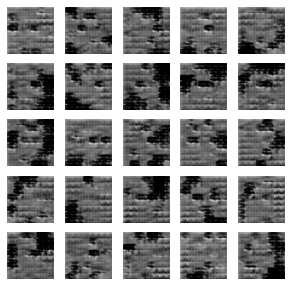

Time for epoch 7 is 399.0 sec
Epoch:  7 | Discriminator Loss:  0.0 | Accuracy:  100.0 % | Generator Loss:  11.98
---------------------------------------------------------------------------------------------------------------------------------------------------------------


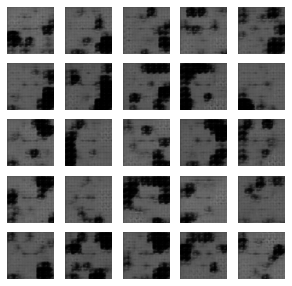

Time for epoch 8 is 401.0 sec
Epoch:  8 | Discriminator Loss:  0.0 | Accuracy:  100.0 % | Generator Loss:  0.0
---------------------------------------------------------------------------------------------------------------------------------------------------------------


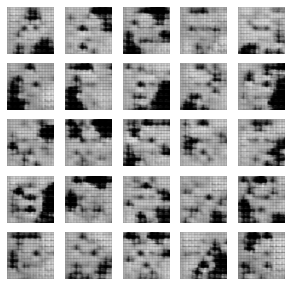

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_5/sequential_3/conv2d_5/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "c:\users\belg\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\users\belg\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Belg\Python\venv\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\Belg\Python\venv\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Belg\Python\venv\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\Belg\Python\venv\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\users\belg\appdata\local\programs\python\python38\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\users\belg\appdata\local\programs\python\python38\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\users\belg\appdata\local\programs\python\python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Belg\Python\venv\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\Belg\Python\venv\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\Belg\Python\venv\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\Belg\Python\venv\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\Belg\Python\venv\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Belg\Python\venv\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Belg\Python\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "C:\Users\Belg\Python\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "C:\Users\Belg\Python\venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Belg\Python\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Belg\Python\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Belg\Python\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Belg\AppData\Local\Temp\ipykernel_964\544606601.py", line 1, in <cell line: 1>
      training()
    File "C:\Users\Belg\AppData\Local\Temp\ipykernel_964\1796077129.py", line 6, in training
      train_step(batch)
    File "C:\Users\Belg\AppData\Local\Temp\ipykernel_964\3175820712.py", line 14, in train_step
      genLoss = gan.train_on_batch(noise,real)
    File "C:\Users\Belg\Python\venv\lib\site-packages\keras\engine\training.py", line 2093, in train_on_batch
      logs = self.train_function(iterator)
    File "C:\Users\Belg\Python\venv\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\Belg\Python\venv\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Belg\Python\venv\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Belg\Python\venv\lib\site-packages\keras\engine\training.py", line 863, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\Belg\Python\venv\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 530, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\Belg\Python\venv\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 583, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "C:\Users\Belg\Python\venv\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 464, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_5/sequential_3/conv2d_5/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[32,32,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_5/sequential_3/conv2d_5/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_5491]

In [23]:
training()

In [ ]:
merged.compile(loss="binary_crossentropy",optimizer="adam")
merged.save("Celeb_a_CNNgeneratorhigher")

discriminator.save("Celeb_a_CNNdiscriminatorhigher")

gan.save("Celeb_a_CNNganhigher")

INFO:tensorflow:Assets written to: Celeb_a_CNNgenerator\assets
INFO:tensorflow:Assets written to: Celeb_a_CNNdiscriminator\assets
INFO:tensorflow:Assets written to: Celeb_a_CNNgan\assets


In [ ]:
model = K.models.load_model("Celeb_a_CNNgeneratorhigher")
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1654784   
                                                                 
 batch_normalization_4 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)     

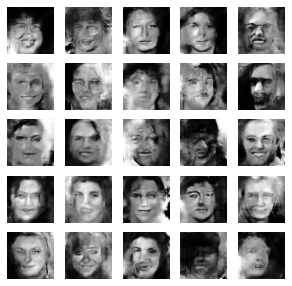

In [ ]:
sampleImg(model)

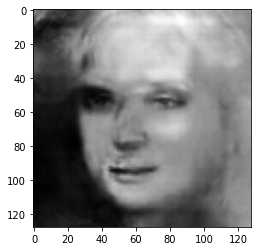

In [ ]:
noise = tf.random.normal([256, 100])
genImg = model.predict(noise)
plt.imshow(genImg[0]* 0.5 + 0.5,cmap="gray")
plt.show()